## Module to perform Multimodal Video and Text Sentimental Analysis
### Sections
* Spanish All features CountVectorizer
* Spanish All Faetures TF-IDF
* English All Features CountVectorizer
* Spanish All Features TF-IDF

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import spacy

In [0]:
!pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_md-2.2.5/es_core_news_md-2.2.5.tar.gz

     |████████████████████████████████| 78.4MB 78kB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.2.5-cp36-none-any.whl size=79649483 sha256=ed9c1433b5ae81998e7359613d0b2542ae8bf472371fc3d31280f04885dc9321
  Stored in directory: /root/.cache/pip/wheels/b7/bb/a3/29ab5cf80c2c0a8fa0f2af8402fdace3f159e8265f0fdcbcdb
Successfully built es-core-news-md


In [0]:
import es_core_news_md
import spacy
nlp=es_core_news_md.load()

# Pre-Processing for Spanish Text

In [0]:
data = pd.read_csv('/content/text_vid.csv')
df = pd.DataFrame(data)

In [0]:
df_v2 = df.copy()
df_V = df.copy()
a = list(df_v2.columns)
a.remove('frame')
a.remove('face_id')
a.remove('timestamp')
a.remove('confidence')
a.remove('success')
a.remove('Unnamed: 0')
b = a.copy()
b.remove('Speech')
b.remove('Sentiment')

df_v2 = df_v2[a]
df_v2 = df_v2.dropna()
df_v2 = df_v2.reset_index(drop=True)

In [0]:
#Lemmatization on individual entries, stored in a list
l=[]
for t in df_v2.Speech:
  s=''
  for i in nlp(t):
    s=s+i.lemma_+' '
  l.append(s)
df_v2['Speech']=l

In [0]:
#import stopwords
from nltk.corpus import stopwords
my_stop_words=list(stopwords.words('spanish'))

In [0]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

from bs4 import BeautifulSoup
import re
def preprocess_text(text):
    #remove html tags
    tags_rem = BeautifulSoup(text, "lxml").get_text()
    #remove non alphabet characters
    letters_only = re.sub("[^a-zA-Z]", " ", tags_rem)
    #make all words lower
    words = letters_only.lower().split()
    #fetch stop words list
    stop_word = set(stopwords.words("spanish"))
    #get list with stop words removed
    final = [w for w in words if not w in stop_word]
    #lemmatime words 
    #new_final = [lemmatizer.lemmatize(w) for w in final]
    return( " ".join(final))


df_v2['Speech'] = df_v2['Speech'].apply(lambda x: preprocess_text(x))

In [0]:
#function to plot roc_auc_curve
def plot_roc_auc(model,X_test,y_test,label):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    #print(lr_probs)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    #print(lr_probs)
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=label)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()# show the plot
    plt.show()

# Count Vectorizer

In [0]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


#Create Vectorizer and remove stopwords
vect=CountVectorizer()
vect.fit(df_v2.Speech)
X_speech=vect.transform(df_v2.Speech)
X_df = pd.DataFrame(X_speech.toarray(), columns=vect.get_feature_names())

df_v2 = df_v2.drop('Speech',axis =1)
horizontal_stack = pd.concat([X_df, df_v2], axis=1)

y = horizontal_stack.Sentiment
X = horizontal_stack.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
# Define the vector of targets and matrix of features

#vect=CountVectorizer() #Remove stopwords
#vect=TfidfVectorizer(stop_words=my_stop_words) #Remove stopwords


# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression(max_iter=100000000).fit(X_train, y_train)
print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', log_reg.score(X_test, y_test))

# Make predictions on the test set
y_predicted1= log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted1))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted1)/len(y_test))

Accuracy on train set:  0.9387186629526463
Accuracy on test set:  0.8
Accuracy score test set:  0.8
Confusion matrix test set: 
 [[0.43333333 0.12222222]
 [0.07777778 0.36666667]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


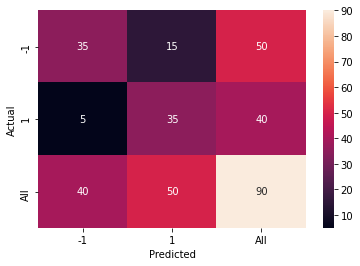

In [0]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test,y_predicted1, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.876


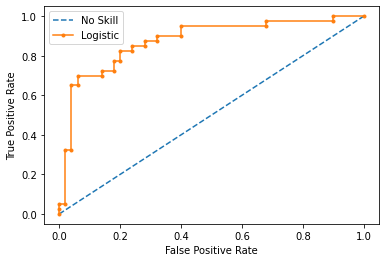

In [0]:
plot_roc_auc(log_reg,X_test,y_test,'Logistic')

### Decision Trees

In [0]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Build a logistic regression model and print out the accuracy
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print('Accuracy on train set: ', clf.score(X_train, y_train))
print('Accuracy on test set: ', clf.score(X_test, y_test))

# Make predictions on the test set
y_predicted = clf.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))

Accuracy on train set:  1.0
Accuracy on test set:  0.7555555555555555
Accuracy score test set:  0.7555555555555555


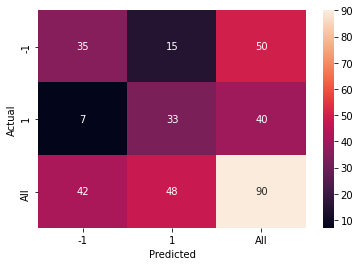

In [0]:
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.762


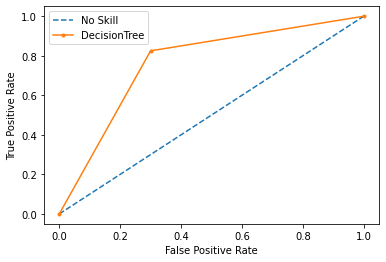

In [0]:
plot_roc_auc(clf,X_test,y_test,'DecisionTree')

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
predictions = []
#Create Model
for i in range(100):
  model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
#run a loop to get the mean score of 100 Random Forest Models as the scores varied everytime we ran it
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(100):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    





# Print the performance metrics
print('Accuracy score test set: ',accuracy_score(y_test, result))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))


Accuracy score test set:  0.8555555555555555
Confusion matrix test set: 
 [[0.38888889 0.16666667]
 [0.07777778 0.36666667]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.922


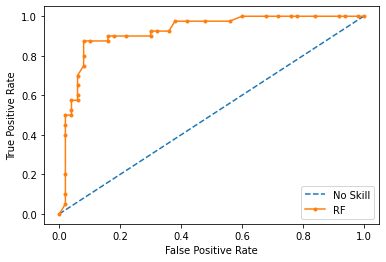

In [0]:
prediction2 = result.copy()
plot_roc_auc(model,X_test,y_test,'RF')

### XGBoost

In [0]:
#Create a svm Classifier
from sklearn import svm
clf = svm.SVC(kernel='linear',probability=True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_predicted = clf.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.6888888888888889
Confusion matrix test set: 
 [[0.4        0.15555556]
 [0.15555556 0.28888889]]


In [0]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()

#Train XGB Model
xg_model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted3 = xg_model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted3))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.8555555555555555
Confusion matrix test set: 
 [[0.38888889 0.16666667]
 [0.07777778 0.36666667]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.897


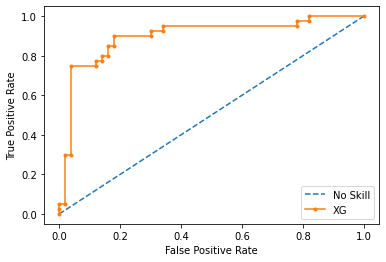

In [0]:
plot_roc_auc(xg_model,X_test,y_test,'XG')

In [0]:
#creating an ensemble of our 3 best performing models
result = []
from collections import Counter
for i in range(len(y_predicted)):
    a = [y_predicted1[i],y_predicted2[i],y_predicted3[i]]
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    

accuracy_score(y_test, result)

0.8666666666666667

# TF-IDF

In [0]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
# Define the vector of targets and matrix of features

vect=TfidfVectorizer() #Remove stopwords
vect.fit(df_v2.Speech)
X_speech=vect.transform(df_v2.Speech)
X_df = pd.DataFrame(X_speech.toarray(), columns=vect.get_feature_names())

df_v2 = df_v2.drop('Speech',axis =1)
horizontal_stack = pd.concat([X_df, df_v2], axis=1)

y = horizontal_stack.Sentiment
X = horizontal_stack.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
# Define the vector of targets and matrix of features

#vect=CountVectorizer() #Remove stopwords
#vect=TfidfVectorizer(stop_words=my_stop_words) #Remove stopwords


# Build a logistic regression model and print out the accuracy
log_reg = LogisticRegression(max_iter=100000000).fit(X_train, y_train)
print('Accuracy on train set: ', log_reg.score(X_train, y_train))
print('Accuracy on test set: ', log_reg.score(X_test, y_test))

# Make predictions on the test set
y_predicted1= log_reg.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted1))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy on train set:  0.935933147632312
Accuracy on test set:  0.7666666666666667
Accuracy score test set:  0.7666666666666667
Confusion matrix test set: 
 [[0.38888889 0.16666667]
 [0.07777778 0.36666667]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


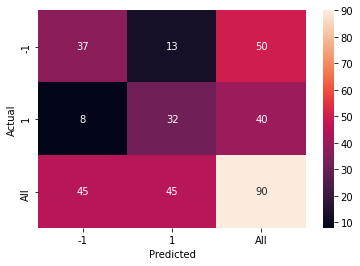

In [0]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test,y_predicted1, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

# Decision Trees

In [0]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Build a logistic regression model and print out the accuracy
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print('Accuracy on train set: ', clf.score(X_train, y_train))
print('Accuracy on test set: ', clf.score(X_test, y_test))

# Make predictions on the test set
y_predicted4 = clf.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted4))

Accuracy on train set:  1.0
Accuracy on test set:  0.7555555555555555
Accuracy score test set:  0.7555555555555555


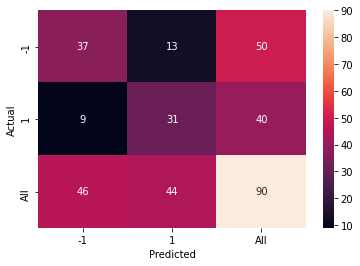

In [0]:
import seaborn as sns
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
predictions = []
#Create Model
for i in range(100):
  model = RandomForestClassifier(bootstrap = True,
                               max_features = 'sqrt', n_estimators= 160, max_depth= 8, min_samples_split= 4, min_samples_leaf= 7)
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(100):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    





# Print the performance metrics
print('Accuracy score test set: ',accuracy_score(y_test, result))


Accuracy score test set:  0.8333333333333334


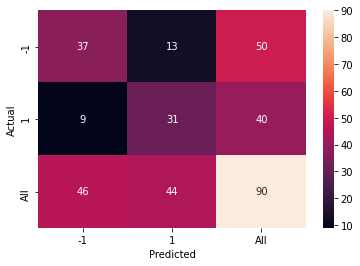

In [0]:
y_predicted2 = result.copy()
import seaborn as sns
confusion_matrix = pd.crosstab(y_test,y_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)
sns.heatmap(confusion_matrix, annot=True)
plt.show()

### XGBoost

In [0]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix

# Define the vector of targets and matrix of feature
# XGB Classifier
xg_model = XGBClassifier()

#Train XGB Model
xg_model.fit(X_train,y_train)

#Predict the response for test dataset
y_predicted3 = xg_model.predict(X_test)

# Print the performance metrics
print('Accuracy score test set: ', accuracy_score(y_test, y_predicted3))
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_predicted)/len(y_test))

Accuracy score test set:  0.8444444444444444
Confusion matrix test set: 
 [[0.41111111 0.14444444]
 [0.1        0.34444444]]


In [0]:
result = []
from collections import Counter
for i in range(len(y_predicted)):
    a = [y_predicted[i],y_predicted2[i],y_predicted3[i]]
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    

accuracy_score(y_test, result)

0.8444444444444444

# English Converted Data

### Pre-Processing

In [0]:
df_eng = pd.read_csv('/content/text_trans.csv')

In [0]:
import pandas as pd
df_merge = pd.merge(df, df_eng, on="Speech")

In [0]:
a = list(df_merge.columns)
a.remove('Unnamed: 0_y')
a.remove('Unnamed: 0.1')
a.remove('Unnamed: 0_x')
a.remove('frame')
a.remove('face_id')
a.remove('timestamp')
a.remove('confidence')
a.remove('success')

In [0]:
df_merge = df_merge[a]

In [0]:
df_merge = df_merge[a]
df_merge = df_merge.dropna()
df_merge = df_merge.reset_index(drop=True)

In [0]:
#Removing Spanish Speech and retaining English Speech
fin_df=df_merge.drop(columns=['sentimentAnnotation','Speech'],axis=1)
fin_df.head()


,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,eye_lmk_x_2,eye_lmk_x_3,eye_lmk_x_4,eye_lmk_x_5,eye_lmk_x_6,eye_lmk_x_7,eye_lmk_x_8,eye_lmk_x_9,eye_lmk_x_10,eye_lmk_x_11,eye_lmk_x_12,eye_lmk_x_13,eye_lmk_x_14,eye_lmk_x_15,eye_lmk_x_16,eye_lmk_x_17,eye_lmk_x_18,eye_lmk_x_19,eye_lmk_x_20,eye_lmk_x_21,eye_lmk_x_22,eye_lmk_x_23,eye_lmk_x_24,eye_lmk_x_25,eye_lmk_x_26,eye_lmk_x_27,eye_lmk_x_28,eye_lmk_x_29,eye_lmk_x_30,eye_lmk_x_31,...,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,Sentiment,EngSpeech
0,0.145450,0.170115,-0.974484,-0.024217,0.172503,-0.984594,0.061809,0.173155,150.246364,151.243636,153.667273,156.100909,157.115455,156.305455,153.702727,151.266364,147.081818,148.502727,150.597273,153.235455,155.921818,157.990000,159.440909,157.792727,155.490000,152.990909,150.632727,148.559091,152.653636,153.719091,154.782727,155.214545,154.767273,153.707273,152.646364,152.215455,180.335455,181.191818,183.522727,185.977273,...,0.025009,-0.016845,0.000327,0.016364,0.007000,0.000000,0.003545,0.000000,0.000000,0.034545,0.00000,0.000000,0.003545,0.052636,0.220818,0.011545,0.057182,0.196818,0.478909,0.078091,0.000000,0.000000,0.000000,0.127273,0.000000,0.000000,0.00000,0.000000,0.000000,0.072727,0.000000,0.136364,0.036364,0.0,0.009091,0.072727,0.0,0.045455,-1,I had seen reviews that said it itchy when you...
1,0.099163,0.153723,-0.933477,-0.061258,0.146968,-0.937428,0.019034,0.152119,152.398305,153.537853,155.985311,158.303955,159.134463,158.159322,155.547458,153.229379,149.266667,150.716384,152.800000,155.396045,158.013559,159.987006,161.324859,159.629944,157.328814,154.871186,152.575141,150.617514,154.697175,155.708475,156.772316,157.276836,156.912429,155.895480,154.825424,154.326554,182.103955,183.149153,185.574576,187.954802,...,0.016644,-0.011627,-0.001554,0.428362,0.562768,0.015367,0.060847,0.003898,0.025537,0.255593,0.00661,0.000000,0.021751,0.177458,0.314576,0.186271,0.082768,0.701469,0.489096,0.277514,0.355932,0.418079,0.056497,0.327684,0.000000,0.033898,0.19209,0.000000,0.000000,0.000000,0.016949,0.282486,0.107345,0.0,0.395480,0.395480,0.0,0.259887,-1,and the truth is that if I use it once and t- ...
2,0.098964,0.185781,-0.976576,-0.072457,0.183415,-0.979240,0.013647,0.186590,151.767626,152.834532,155.276978,157.660432,158.594245,157.701439,155.080576,152.693525,148.656835,150.061151,152.130935,154.738849,157.410072,159.457554,160.884892,159.190647,156.864748,154.378417,152.044604,150.041727,154.134532,155.178417,156.238849,156.705755,156.303597,155.264029,154.194964,153.720863,182.102878,183.039568,185.451799,187.932374,...,0.027597,0.005396,-0.005698,0.225899,0.003669,0.000647,0.017914,0.073237,0.077266,0.103453,0.00000,0.093597,0.151367,0.041295,0.408705,0.160576,0.139496,0.808273,0.783597,0.198273,0.028777,0.000000,0.000000,0.000000,0.143885,0.532374,0.05036,0.043165,0.071942,0.517986,0.035971,0.474820,0.237410,0.0,0.446043,0.230216,0.0,0.136691,-1,and I said no: it could be possible so much I ...
3,0.103902,0.192929,-0.975292,-0.068309,0.206512,-0.975669,0.018221,0.201947,147.027368,147.827895,150.089474,152.492105,153.631579,153.024737,150.567895,148.166316,144.168947,145.374211,147.281053,149.758421,152.395789,154.481053,156.019474,154.441053,152.208947,149.814737,147.555263,145.593684,149.436316,150.487368,151.478421,151.826316,151.325789,150.281053,149.287368,148.938421,176.465263,177.177368,179.446316,181.950526,...,0.017421,-0.022632,-0.004968,0.094474,0.087000,0.000000,0.135947,0.001158,0.031211,0.019947,0.00000,0.000000,0.019789,0.284789,0.846947,0.324158,0.054789,0.624579,0.831789,0.674474,0.000000,0.089474,0.000000,0.394737,0.000000,0.015789,0.00000,0.000000,0.000000,0.015789,0.110526,0.721053,0.526316,0.0,0.178947,0.026316,0.0,0.557895,-1,It also p

In [0]:
#import english stopwords
from nltk.corpus import stopwords
eng_stop_words=list(stopwords.words('english'))

In [0]:
from bs4 import BeautifulSoup
import re
def preprocess_text(text):
    #remove html tags
    tags_rem = BeautifulSoup(text, "lxml").get_text()
    #remove non alphabet characters
    letters_only = re.sub("[^a-zA-Z]", " ", tags_rem)
    #make all words lower
    words = letters_only.lower().split()
    #fetch stop words list
    stop_word = set(stopwords.words("english"))
    #get list with stop words removed
    final = [w for w in words if not w in stop_word]
    return( " ".join( final))


fin_df['EngSpeech'] = fin_df['EngSpeech'].apply(lambda x: preprocess_text(x))

### CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#Lemmatizer Function
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

#Create Vectorizer and remove stopwords
vect=CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=eng_stop_words)
vect.fit(fin_df.EngSpeech)
fin_speech=vect.transform(fin_df.EngSpeech)



Eng_df = pd.DataFrame(fin_speech.toarray(), columns=vect.get_feature_names())
fin_df = fin_df.drop('EngSpeech',axis =1)
horizontal_stack = pd.concat([Eng_df, fin_df], axis=1)

#Dataframe after removing stopwords







[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
y = horizontal_stack.Sentiment
X = horizontal_stack.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
X

,abbey,able,absolutely,academy,according,account,achieve,acid,actor,actress,actually,add,additional,adiction,adore,afternoon,agh,ago,ah,al,allergic,almost,already,also,although,altogether,always,american,amount,anger,another,antioxidant,anymore,anyone,anything,apart,ape,appears,apply,applying,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.004391,0.004136,0.025009,-0.016845,0.000327,0.016364,0.007000,0.000000,0.003545,0.000000,0.000000,0.034545,0.000000,0.000000,0.003545,0.052636,0.220818,0.011545,0.057182,0.196818,0.478909,0.078091,0.000000,0.000000,0.000000,0.127273,0.000000,0.000000,0.000000,0.000000,0.000000,0.072727,0.000000,0.136364,0.036364,0.000000,0.009091,0.072727,0.0,0.045455
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.003977,0.001893,0.016644,-0.011627,-0.001554,0.428362,0.562768,0.015367,0.060847,0.003898,0.025537,0.255593,0.006610,0.000000,0.021751,0.177458,0.314576,0.186271,0.082768,0.701469,0.489096,0.277514,0.355932,0.418079,0.056497,0.327684,0.000000,0.033898,0.192090,0.000000,0.000000,0.000000,0.016949,0.282486,0.107345,0.000000,0.395480,0.395480,0.0,0.259887
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.013791,-0.014863,0.027597,0.005396,-0.005698,0.225899,0.003669,0.000647,0.017914,0.073237,0.077266,0.103453,0.000000,0.093597,0.151367,0.041295,0.408705,0.160576,0.139496,0.808273,0.783597,0.198273,0.028777,0.000000,0.000000,0.000000,0.143885,0.532374,0.050360,0.043165,0.071942,0.517986,0.035971,0.474820,0.237410,0.000000,0.446043,0.230216,0.0,0.136691
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.001584,-0.003189,0.017421,-0.022632,-0.004968,0.094474,0.087000,0.000000,0.135947,0.001158,0.031211,0.019947,0.000000,0.000000,0.019789,0.284789,0.846947,0.324158,0.054789,0.624579,0.831789,0.674474,0.000000,0.089474,0.000000,0.394737,0.000000,0.015789,0.000000,0.000000,0.000000,0.015789,0.110526,0.721053,0.526316,0.000000,0.178947,0.026316,0.0,0.557895
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.002098,0.012427,0.018610,-0.011293,0.002951,0.124390,0.012683,0.000000,0.000000,0.001585,0.001098,0.013659,0.000000,0.000000,0.000000,0.140000,0.314878,0.134756,0.034512,0.449756,0.918659,0.115244,0.000000,0.109756,0.000000,0.036585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158537,0.353659,0.121951,0.000000,0.280488,0.195122,0.0,0.182927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.067163,-0.013930,-0.041031,0.024930,-0.025016,0.509380,0.226977,0.054729,0.039690,0.429690,0.382946,0.000930,0.813798,0.617364,0.161318,0.134806,0.408682,0.134109,0.292946,0.356202,0.334651,0.285349,0.279070,0.542636,0.100775,0.457364,0.767442,0.813953,0.000000,0.860465,0.511628,0.379845,0.000000,0.155039,0.015504,0.000000,0.248062,0.062016,0.0,0.232558
445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.037599,0.051500,-0.001542,0.008521,-0.024880,0.504323,0.002031,0.572031,0.061927,0.362135,0.851354,0.125052,0.602708,0.211927,0.149167,0.230781,0.366563,0.056354,0.233437,0.519948,0.842969,0.138333,0.354167,0.062500,0.677083,0.453125,0.687500,0.791667,0.098958,0.708333,0.130208,0.125000,0.453125,0.265625,0.000000,0.020833,0.479167,0.380208,0.0,0.30

In [0]:
#single cell, best models

log_reg = LogisticRegression(max_iter=100000000).fit(X_train, y_train)
print('LogReg Score is ', log_reg.score(X_test,y_test))
xg_model = XGBClassifier()
#Train XGB Model
xg_model.fit(X_train,y_train)
print('XGBoost Score is ', xg_model.score(X_test,y_test))

predictions = []
#Create Model
for i in range(100):
  model = RandomForestClassifier(bootstrap = True,
                               max_features = 'sqrt', n_estimators= 160, max_depth= 8, min_samples_split= 4, min_samples_leaf= 7)
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(100):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    
# Print the performance metrics
print('Random Forest Score: ',accuracy_score(y_test, result))



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogReg Score is  0.8111111111111111
XGBoost Score is  0.8222222222222222
Random Forest Score:  0.8333333333333334


### TF-IDF

In [0]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
# Define the vector of targets and matrix of features
#Lemmatizer Function
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

#Create Vectorizer and remove stopwords
vect=TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=eng_stop_words) #Remove stopwords)
vect.fit(fin_df.EngSpeech)
fin_speech=vect.transform(fin_df.EngSpeech)


Eng_df = pd.DataFrame(fin_speech.toarray(), columns=vect.get_feature_names())
fin_df = fin_df.drop('EngSpeech',axis =1)
horizontal_stack = pd.concat([Eng_df, fin_df], axis=1)

y = horizontal_stack.Sentiment
X = horizontal_stack.drop('Sentiment', axis=1)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [0]:
X

,abbey,able,absolutely,academy,according,account,achieve,acid,actor,actress,actually,add,additional,adiction,adore,afternoon,agh,ago,ah,al,allergic,almost,already,also,although,altogether,always,american,amount,anger,another,antioxidant,anymore,anyone,anything,apart,ape,appears,apply,applying,...,p_29,p_30,p_31,p_32,p_33,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004391,0.004136,0.025009,-0.016845,0.000327,0.016364,0.007000,0.000000,0.003545,0.000000,0.000000,0.034545,0.000000,0.000000,0.003545,0.052636,0.220818,0.011545,0.057182,0.196818,0.478909,0.078091,0.000000,0.000000,0.000000,0.127273,0.000000,0.000000,0.000000,0.000000,0.000000,0.072727,0.000000,0.136364,0.036364,0.000000,0.009091,0.072727,0.0,0.045455
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003977,0.001893,0.016644,-0.011627,-0.001554,0.428362,0.562768,0.015367,0.060847,0.003898,0.025537,0.255593,0.006610,0.000000,0.021751,0.177458,0.314576,0.186271,0.082768,0.701469,0.489096,0.277514,0.355932,0.418079,0.056497,0.327684,0.000000,0.033898,0.192090,0.000000,0.000000,0.000000,0.016949,0.282486,0.107345,0.000000,0.395480,0.395480,0.0,0.259887
2,0.0,0.383251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.013791,-0.014863,0.027597,0.005396,-0.005698,0.225899,0.003669,0.000647,0.017914,0.073237,0.077266,0.103453,0.000000,0.093597,0.151367,0.041295,0.408705,0.160576,0.139496,0.808273,0.783597,0.198273,0.028777,0.000000,0.000000,0.000000,0.143885,0.532374,0.050360,0.043165,0.071942,0.517986,0.035971,0.474820,0.237410,0.000000,0.446043,0.230216,0.0,0.136691
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.181709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001584,-0.003189,0.017421,-0.022632,-0.004968,0.094474,0.087000,0.000000,0.135947,0.001158,0.031211,0.019947,0.000000,0.000000,0.019789,0.284789,0.846947,0.324158,0.054789,0.624579,0.831789,0.674474,0.000000,0.089474,0.000000,0.394737,0.000000,0.015789,0.000000,0.000000,0.000000,0.015789,0.110526,0.721053,0.526316,0.000000,0.178947,0.026316,0.0,0.557895
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.002098,0.012427,0.018610,-0.011293,0.002951,0.124390,0.012683,0.000000,0.000000,0.001585,0.001098,0.013659,0.000000,0.000000,0.000000,0.140000,0.314878,0.134756,0.034512,0.449756,0.918659,0.115244,0.000000,0.109756,0.000000,0.036585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158537,0.353659,0.121951,0.000000,0.280488,0.195122,0.0,0.182927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640587,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.067163,-0.013930,-0.041031,0.024930,-0.025016,0.509380,0.226977,0.054729,0.039690,0.429690,0.382946,0.000930,0.813798,0.617364,0.161318,0.134806,0.408682,0.134109,0.292946,0.356202,0.334651,0.285349,0.279070,0.542636,0.100775,0

In [0]:
#single cell, best models

log_reg = LogisticRegression(max_iter=100000000).fit(X_train, y_train)
print('LogReg Score is ', log_reg.score(X_test,y_test))
xg_model = XGBClassifier()
#Train XGB Model
xg_model.fit(X_train,y_train)
print('XGBoost Score is ', xg_model.score(X_test,y_test))

predictions = []
#Create Model
for i in range(10):
  model = RandomForestClassifier(bootstrap = True,
                               max_features = 'sqrt', n_estimators= 160, max_depth= 8, min_samples_split= 4, min_samples_leaf= 7)
  # Fit on training data
  model.fit(X_train,y_train)
  #Predict the response for test dataset
  y_predicted2 = model.predict(X_test)
  predictions.append(y_predicted2)

result = []
from collections import Counter
for i in range(len(y_predicted2)):
    a = []
    for j in range(10):
      a.append(predictions[j][i])
    #print(a)
    b = Counter(a)
    result.append(b.most_common(1)[0][0])
    
# Print the performance metrics
print('Random Forest Score: ',accuracy_score(y_test, result))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogReg Score is  0.8
XGBoost Score is  0.8
Random Forest Score:  0.8333333333333334


# Conclusion and Results

* Adding Facial Features to the Text Data augments the accuracy of the prediction, indicating a correlation between the words spoken and the expressions made.
* Spanish Text + Video model gives a higher accuracy over English Text + Video model, indicating a loss in correlation which occurs due to the conversion of text.
* 85.55 % is the highest score obtained which could improve upon Feature Reduction.